<a href="https://colab.research.google.com/github/SeongwonTak/Data_Practices/blob/master/LSTM__%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A1%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 통한 예측(시계열 예측 실습)
LSTM을 통한 시계열 분석을 통한 예측 실습  
**서울의 기온 예측하기**  
데이처 출처 : https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim

In [2]:
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/seoul_temp_csv.csv')
df

,Date,avg_temp,min_temp,max_temp
0,2020-01-01,-2.2,-6.5,0.3
1,2020-01-02,1.0,-0.7,3.8
2,2020-01-03,-0.1,-3.4,4.6
3,2020-01-04,1.2,-2.8,6.1
4,2020-01-05,1.3,-3.2,6.6
...,...,...,...,...
594,2021-08-17,25.9,21.9,31.3
595,2021-08-18,24.3,20.6,31.0
596,2021-08-19,26.0,21.0,31.5
597,2021-08-20,26.6,22.6,30.7


In [3]:
df = df.set_index('Date', drop = True)
df

,avg_temp,min_temp,max_temp
Date,,,
2020-01-01,-2.2,-6.5,0.3
2020-01-02,1.0,-0.7,3.8
2020-01-03,-0.1,-3.4,4.6
2020-01-04,1.2,-2.8,6.1
2020-01-05,1.3,-3.2,6.6
...,...,...,...
2021-08-17,25.9,21.9,31.3
2021-08-18,24.3,20.6,31.0
2021-08-19,26.0,21.0,31.5


## 데이터 탐색

In [4]:
df.isna().sum()

avg_temp    0
min_temp    0
max_temp    0
dtype: int64

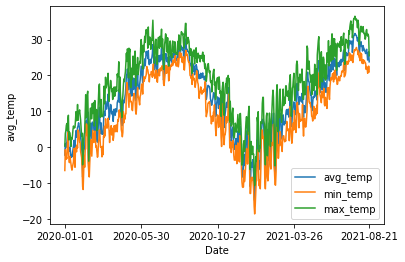

In [5]:
sns.lineplot(x = 'Date', y = 'avg_temp', data = df, label = 'avg_temp')
sns.lineplot(x = 'Date', y = 'min_temp', data = df, label = 'min_temp')
sns.lineplot(x = 'Date', y = 'max_temp', data = df, label = 'max_temp')
plt.legend()
plt.xticks([0, 150, 300, 450, 598])
plt.show()

**목표**

2020/01/01 ~ 2021/07/31의 최소 온도와, 최대 온도를 바탕으로 
2021/08/01 ~ 2021/08/31의 평균 온도를 예측하는 모델을 만들어보고자 한다.

## LSTM Model

In [6]:
X = df[['min_temp', 'max_temp']]
y = df['avg_temp']


# 스케일링은 최대와 최소의 범주를 확인할 수 있는, Min-Max를 활용한다.
scaler = MinMaxScaler()
Xscaler = scaler.fit(X)
yscaler = scaler.fit(y.values.reshape(-1, 1))

X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1, 1))


# 8/1 ~ 8/21 데이터에 대해서 분리해야 한다.
test_data_size = 21
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [7]:
# LSTM을 위해서는 시퀀스 데이터 형태로 바꿔줘야 한다. 이를 위한 작업을 실시.

def get_seq(array, seq_length):
  seq = []
  for i in range(len(array)-(seq_length-1)):
    seq.append(array[i:(i+seq_length)])
  
  return seq

In [8]:
seq_length = 1

X_train = get_seq(X_train, seq_length)
X_test = get_seq(X_test, seq_length)
y_train = get_seq(y_train, seq_length)
y_test = get_seq(y_test, seq_length)

In [9]:
# 현재는 numpy 이므로 torch에서 사용 가능한 tensor 형태로 변환한다.
import torch
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [101]:
class TempPredictor(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(TempPredictor, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                        num_layers = num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
    h_n = h_n.view(-1, self.hidden_size)
    out = self.fc(h_n)

    return out

In [106]:
num_epochs = 500
learning_rate = 0.001

input_size = 2
hidden_size = 128
num_layers = 1
num_classes = 1

model = TempPredictor(num_classes, input_size, hidden_size, num_layers, X_train)

loss_ftn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [107]:
y_train_resize = y_train.view([-1, 1])

for epoch in range(num_epochs):
  outputs = model.forward(X_train)
  optimizer.zero_grad()

  loss = loss_ftn(outputs, y_train_resize)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print('Epoch : %d, loss : %2.5f' % (epoch, loss.item()))

Epoch : 0, loss : 0.45451
Epoch : 100, loss : 0.01453
Epoch : 200, loss : 0.00636
Epoch : 300, loss : 0.00075
Epoch : 400, loss : 0.00024


In [108]:
y_pred = model(X_test)

In [109]:
y_pred

tensor([[0.9018],
        [0.8984],
        [0.9173],
        [0.9650],
        [0.9615],
        [0.9502],
        [0.9181],
        [0.9287],
        [0.9310],
        [0.9285],
        [0.9194],
        [0.9193],
        [0.8943],
        [0.8987],
        [0.8976],
        [0.9121],
        [0.8883],
        [0.8687],
        [0.8791],
        [0.8907],
        [0.8151]], grad_fn=<AddmmBackward>)

In [110]:
y_pred = yscaler.inverse_transform(y_pred.data.numpy())

In [111]:
y_pred

array([[27.124367],
       [26.964771],
       [27.845081],
       [30.067654],
       [29.90487 ],
       [29.378983],
       [27.885399],
       [28.37709 ],
       [28.48414 ],
       [28.368416],
       [27.946175],
       [27.937502],
       [26.77641 ],
       [26.977587],
       [26.930464],
       [27.604994],
       [26.495564],
       [25.581043],
       [26.066166],
       [26.606588],
       [23.084902]], dtype=float32)

In [113]:
df

,avg_temp,min_temp,max_temp
Date,,,
2020-01-01,-2.2,-6.5,0.3
2020-01-02,1.0,-0.7,3.8
2020-01-03,-0.1,-3.4,4.6
2020-01-04,1.2,-2.8,6.1
2020-01-05,1.3,-3.2,6.6
...,...,...,...
2021-08-17,25.9,21.9,31.3
2021-08-18,24.3,20.6,31.0
2021-08-19,26.0,21.0,31.5


In [121]:
df_cut = df.iloc[578:599,:]
df_cut

,avg_temp,min_temp,max_temp
Date,,,
2021-08-01,27.1,25.1,28.8
2021-08-02,26.5,25.0,28.6
2021-08-03,28.0,24.1,31.4
2021-08-04,28.9,26.3,33.2
2021-08-05,29.4,25.6,33.7
2021-08-06,28.1,26.0,32.2
2021-08-07,28.0,23.4,32.3
2021-08-08,26.8,24.4,32.1
2021-08-09,28.3,23.3,33.6


In [122]:
df_cut['y_pred'] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
df_cut

,avg_temp,min_temp,max_temp,y_pred
Date,,,,
2021-08-01,27.1,25.1,28.8,27.124367
2021-08-02,26.5,25.0,28.6,26.964771
2021-08-03,28.0,24.1,31.4,27.845081
2021-08-04,28.9,26.3,33.2,30.067654
2021-08-05,29.4,25.6,33.7,29.904869
2021-08-06,28.1,26.0,32.2,29.378983
2021-08-07,28.0,23.4,32.3,27.885399
2021-08-08,26.8,24.4,32.1,28.377090
2021-08-09,28.3,23.3,33.6,28.484140


## 결과 평가

In [124]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_cut.avg_temp, df_cut.y_pred)

0.5464164237733138

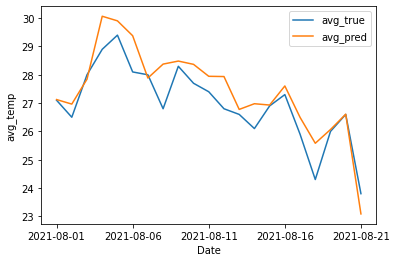

In [125]:
sns.lineplot(x = 'Date', y = 'avg_temp', data = df_cut, label = 'avg_true')
sns.lineplot(x = 'Date', y = 'y_pred', data = df_cut, label = 'avg_pred')
plt.legend()
plt.xticks([0, 5, 10, 15, 20])
plt.show()

시각화를 통해 비교해본 결과, 비슷한 패턴을 보이나 전체적으로 예측 결과가 실제 값에 비해 더 높은 값으로 예측하는 경향을 가지고 있다.